In [23]:
YEAR = "2017"

In [24]:
import glob
import json
import pathlib
import sys
import re
from decimal import *
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def read_judgments_jsons(files):
    for path in files:
        yield json.loads(pathlib.Path(path).read_text())


def items_from_judgments_jsons(judgments):
    for judgment in judgments:
        for item in judgment["items"]:
            yield item


def is_correct_judgment_year(year):
    return lambda item:item["judgmentDate"][:4] == year

In [26]:
def get_multiplier(expression):
    word_to_multiplier_tuples = {
        ("tysiąc", "tysiące", "tysiąca", "tysięcy", "tys", "tys."): 10**3,
        ("milion", "miliony", "miliona", "milionów", "mln" , "mln."): 10**6,
        ("miliard", "miliardy", "miliarda", "miliardów", "mld", "mld."): 10**9
    }
    word_to_multiplier = {
        word: multiplier
        for tup, multiplier in word_to_multiplier_tuples.items()
        for word in tup
    }

    for current_word in word_to_multiplier:
        if re.search("{}".format(current_word), expression):
            return word_to_multiplier[current_word]

    return 1

def extract_money_amounts_from_text(text):
    number_catch_group = r"(\d[\d,\.\s]*)"
    potential_multiplier = r"(\s\w+\s)?"
    round_brackets = r"(\([^\)]*?\))?"

    regex = r"{number_catch_group}\s*?{potential_multiplier}\s*?{round_brackets}\s*?{potential_multiplier}\s*?zł".format(
        number_catch_group=number_catch_group,
        potential_multiplier=potential_multiplier,
        round_brackets=round_brackets
    )

    for match in re.finditer(regex, text):
        try:
            if match.group(0).find("starych") != -1:
                continue

            # print(match.group(0), end="")
            number = match.group(1)

            # remove unecessary dots
            number = number.replace(".", "")

            # convert polish ',' decimal seperator to english
            number = number.replace(",", ".")

            # remove whitespaces between digits
            number = re.sub(r"\s", "", number)
            dec = Decimal(number)


            m = match.group(0)
            # remove round brackets
            m = re.sub("\(.*?\)", "", m)

            # print("    " + m + "    ", end="")

            multiplier = get_multiplier(m)
            money_amount = int(dec * multiplier)

            if money_amount > 10**14:
                continue


            yield money_amount
        except Exception as e:
            pass
            #print("{} for \"{}\" match".format(e, match.group(0)), file=sys.stderr)

In [27]:
def show_histogram(name, data, bins):
    plt.hist(data, bins)
    plt.gca().set_xscale("log")

    plt.title(name)
    plt.xlabel("Money values")
    plt.ylabel("Occurrences")
    plt.grid(True)
    plt.show()

In [28]:
files = glob.glob("data/json/judgments*.json")

judgments_jsons = read_judgments_jsons(files)
items = items_from_judgments_jsons(judgments_jsons)

money_amounts = []

for item in filter(is_correct_judgment_year(YEAR), items):
    text_content = item["textContent"]
    money_amounts.extend(extract_money_amounts_from_text(text_content))

print(len(money_amounts))

694704


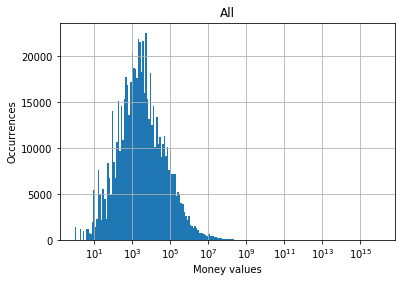

In [29]:
show_histogram("All", money_amounts, bins=np.logspace(0, 16, 200))

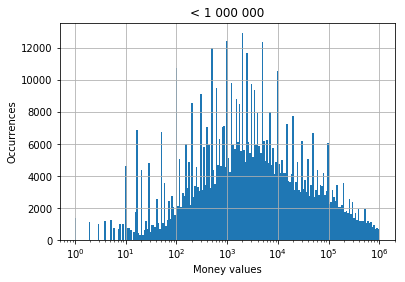

In [30]:
show_histogram("< 1 000 000",
               [x for x in money_amounts if x < 10**6],
               bins=np.logspace(0, 6, 200))

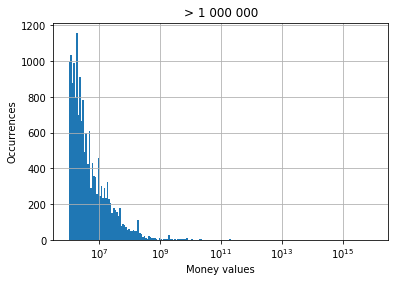

In [31]:
show_histogram("> 1 000 000", 
               [x for x in money_amounts if x > 10**6],
               bins=np.logspace(6, 16, 200))

In [ ]:
judgments_jsons = read_judgments_jsons(files)
items = items_from_judgments_jsons(judgments_jsons)
for item in filter(is_correct_judgment_year(YEAR), items):
    text_content = item["textContent"]

In [32]:
number_of_judgments = 0
number_of_judgments_containing_given_word = 0

judgments_jsons = read_judgments_jsons(files)
items = items_from_judgments_jsons(judgments_jsons)
for item in filter(is_correct_judgment_year(YEAR), items):
    text_content = item["textContent"]
    word_forms = (
        "szkoda", 
        "szkodą", 
        "szkodę", 
        "szkodo", 
        "szkody", 
        "szkodzie", 
        "szkodach", 
        "szkodami", 
        "szkodom", 
        "szkód"
    )

    if re.search("|".join(word_forms), text_content):
        number_of_judgments_containing_given_word += 1
    number_of_judgments += 1
    
print(r"{} / {}".format(number_of_judgments_containing_given_word, number_of_judgments))

19302 / 44719
